In [1]:
import matplotlib.patches as patches
import matplotlib.pyplot as plt
import numpy as np
import math
from operator import itemgetter
from scipy import interpolate
from ctypes import *
from scipy import ndimage
from matplotlib.pyplot import imshow
from PIL import Image, ImageDraw, ImageFilter
import cv2 
import random
from scipy.ndimage.filters import generic_filter

# Метод роста областей

In [2]:
class Method_of_grow:
    def __init__(self, im_path,th):
        self.im = cv2.resize(cv2.imread(im_path, 1), (256, 256))
        self.h, self.w, _ = self.im.shape
        self.passed_by = np.zeros((self.h, self.w), np.double)
        self.current_region = 0
        self.iterations = 0
        self.segments = np.zeros((self.h, self.w, 3), dtype='uint8')
        self.stack = []
        self.thresh = float(th)

        

    def get_neighbour(self, x0, y0):
        neighbour = []
        for i in (-1, 0, 1):
            for j in (-1, 0, 1):
                if (i, j) == (0, 0):
                    continue
                x = x0 + i
                y = y0 + j
                if self.limit(x, y):
                    neighbour.append((x, y))
        return neighbour

    def apply_region_grow(self):
        random_seeds = [[self.h / 2, self.w / 2],
                       [self.h / 3, self.w / 3], [2 * self.h / 3, self.w / 3], [self.h / 3 - 10, self.w / 3],
                       [self.h / 3, 2 * self.w / 3], [2 * self.h / 3, 2 * self.w / 3],
                       [self.h / 3 - 10, 2 * self.w / 3],
                       [self.h / 3, self.w - 10], [2 * self.h / 3, self.w - 10], [self.h / 3 - 10, self.w - 10]
                       ]
        np.random.shuffle(random_seeds)
        for x0 in range(self.h):
            for y0 in range(self.w):
                if self.passed_by[x0, y0] == 0 and (
                        int(self.im[x0, y0, 0]) * int(self.im[x0, y0, 1]) * int(self.im[x0, y0, 2]) > 0):
                    self.current_region += 1
                    self.passed_by[x0, y0] = self.current_region
                    self.stack.append((x0, y0))
                    self.prev_region_count = 0
                    while not len(self.stack) == 0:
                        x, y = self.stack.pop()
                        self.bfs(x, y)
                        self.iterations += 1
                    if self.passed_all():
                        break
                    if self.prev_region_count < 8 * 8:
                        self.passed_by[self.passed_by == self.current_region] = 0
                        x0 = random.randint(x0 - 4, x0 + 4)
                        x0 = max(0, x0)
                        x0 = min(x0, self.h - 1)
                        self.current_region -= 1

        for i in range(0, self.h):
            for j in range(0, self.w):
                val = self.passed_by[i][j]
                if val == 0:
                    self.segments[i][j] = 255, 255, 255
                else:
                    self.segments[i][j] = val * 35, val * 90, val * 30
        return self.segments

    def bfs(self, x0, y0):
        region_num = self.passed_by[x0, y0]
        elements = [(int(self.im[x0, y0, 0]) + int(self.im[x0, y0, 1]) + int(self.im[x0, y0, 2])) / 3]
        var = self.thresh
        neighbours = self.get_neighbour(x0, y0)
        for x, y in neighbours:
            if self.passed_by[x, y] == 0 and self.distance(x, y, x0, y0) < var:
                if self.passed_all():
                    break
                self.passed_by[x, y] = region_num
                self.stack.append((x, y))
                elements.append((int(self.im[x, y, 0]) + int(self.im[x, y, 1]) + int(self.im[x, y, 2])) / 3)
                var = np.var(elements)
                self.prev_region_count += 1
            var = max(var, self.thresh)

    def passed_all(self):
        return self.iterations > 200000 or np.count_nonzero(self.passed_by > 0) == self.w * self.h

    def limit(self, x, y):
        return 0 <= x < self.h and 0 <= y < self.w

    def distance(self, x, y, x0, y0):
        return ((int(self.im[x, y, 0]) - int(self.im[x0, y0, 0])) ** 2 + (
                int(self.im[x, y, 1]) - int(self.im[x0, y0, 1])) ** 2 + (
                        int(self.im[x, y, 2]) - int(self.im[x0, y0, 2])) ** 2) ** 0.5

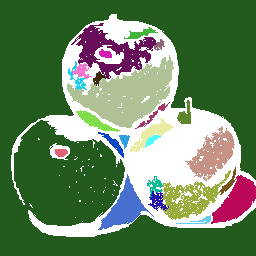

In [6]:
result_img = Method_of_grow("images/14.jpg",6)
saving = Image.fromarray(result_img.apply_region_grow()).convert("RGB")
saving.save('images/Сегментация изображения.jpg', "JPEG")
saving